In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os

import glob

from ultralytics import FastSAM

In [2]:
root = "data/test_crystal_capture"

In [3]:
files = glob.glob(os.path.join(root, "*.png"))

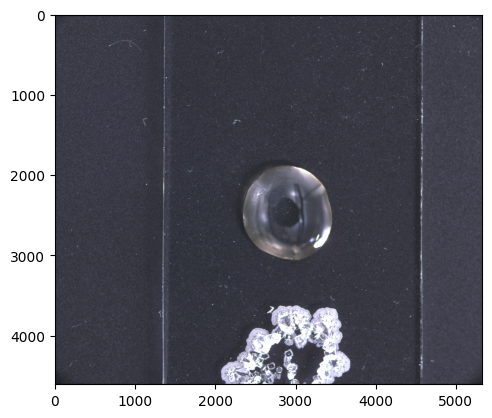

In [4]:
img = cv2.imread(files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

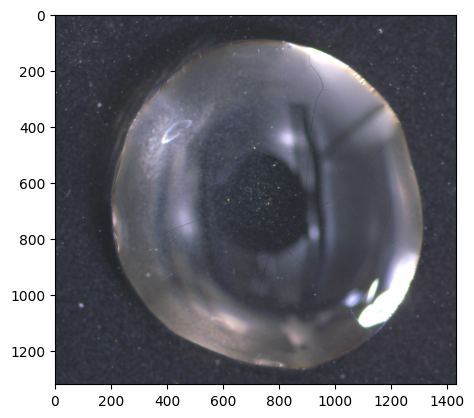

In [5]:
# select a region of interest with the mouse
window = cv2.namedWindow("Select ROI", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Select ROI", int(img.shape[1]/4), int(img.shape[0]/4))
roi = cv2.selectROI("Select ROI", img)
cv2.destroyAllWindows()
cropped_img = img[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]
plt.figure()
plt.imshow(cropped_img)
plt.show()

In [6]:
cropped_dir = os.path.join(root, "cropped")
os.makedirs(cropped_dir, exist_ok=True)

In [7]:
for file in files:
    filename = os.path.basename(file)
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cropped_img = img[int(roi[1]):int(roi[1]+roi[3]), int(roi[0]):int(roi[0]+roi[2])]

    if os.path.exists(os.path.join(cropped_dir, filename)):
        print(f"Skipping saving cropped img for {filename}")
        continue
    cv2.imwrite(os.path.join(cropped_dir, filename), cv2.cvtColor(cropped_img, cv2.COLOR_RGB2BGR))

Skipping saving cropped img for 2024-08-29_13-38-11.png
Skipping saving cropped img for 2024-08-29_15-16-11.png
Skipping saving cropped img for 2024-08-29_15-28-56.png
Skipping saving cropped img for 2024-08-29_15-53-56.png
Skipping saving cropped img for 2024-08-29_16-17-56.png
Skipping saving cropped img for 2024-08-29_16-41-56.png
Skipping saving cropped img for 2024-08-29_16-59-26.png
Skipping saving cropped img for 2024-08-29_17-17-27.png
Skipping saving cropped img for 2024-08-29_17-36-27.png
Skipping saving cropped img for 2024-08-29_17-46-42.png
Skipping saving cropped img for 2024-08-29_17-58-27.png


In [8]:
cropped_files = glob.glob(os.path.join(cropped_dir, "*.png"))


0: 1024x992 8 objects, 4047.0ms
Speed: 7.5ms preprocess, 4047.0ms inference, 54.0ms postprocess per image at shape (1, 3, 1024, 992)


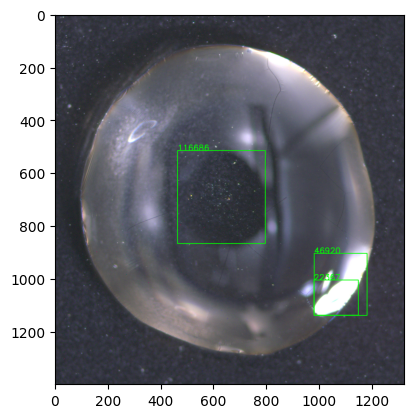


0: 1024x992 8 objects, 3871.5ms
Speed: 6.5ms preprocess, 3871.5ms inference, 54.5ms postprocess per image at shape (1, 3, 1024, 992)


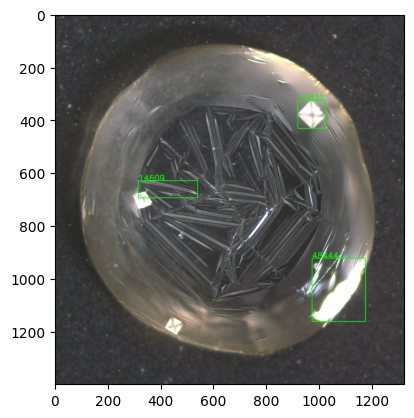


0: 1024x992 8 objects, 4264.5ms
Speed: 10.0ms preprocess, 4264.5ms inference, 58.0ms postprocess per image at shape (1, 3, 1024, 992)


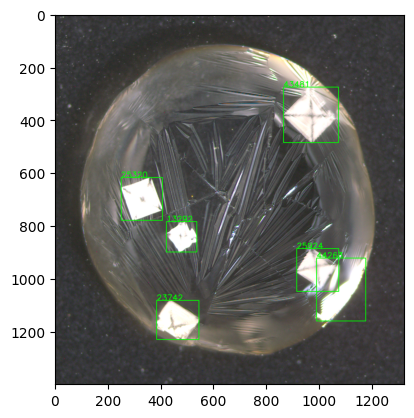


0: 1024x992 10 objects, 4172.5ms
Speed: 7.0ms preprocess, 4172.5ms inference, 71.5ms postprocess per image at shape (1, 3, 1024, 992)


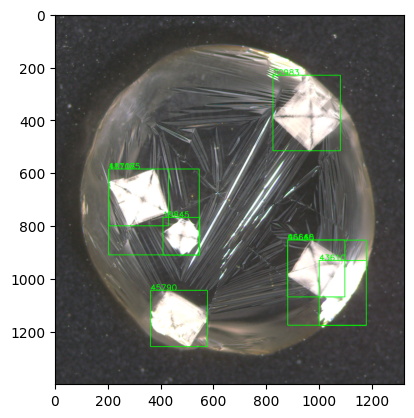


0: 1024x992 13 objects, 4027.0ms
Speed: 7.5ms preprocess, 4027.0ms inference, 96.0ms postprocess per image at shape (1, 3, 1024, 992)


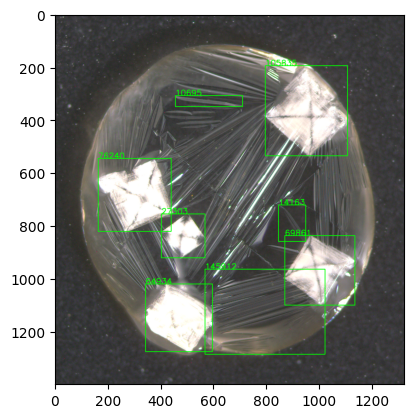


0: 1024x992 12 objects, 4143.5ms
Speed: 9.0ms preprocess, 4143.5ms inference, 82.5ms postprocess per image at shape (1, 3, 1024, 992)


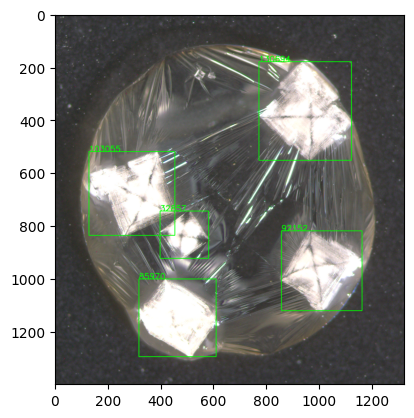


0: 1024x992 11 objects, 4093.5ms
Speed: 7.5ms preprocess, 4093.5ms inference, 77.5ms postprocess per image at shape (1, 3, 1024, 992)


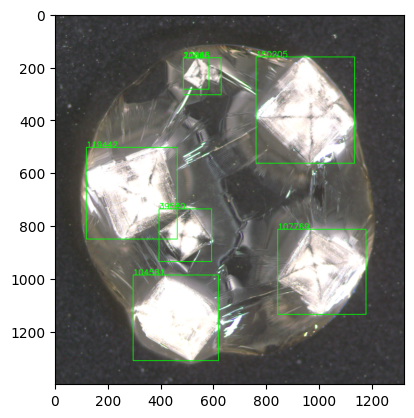


0: 1024x992 9 objects, 4210.0ms
Speed: 9.0ms preprocess, 4210.0ms inference, 63.0ms postprocess per image at shape (1, 3, 1024, 992)


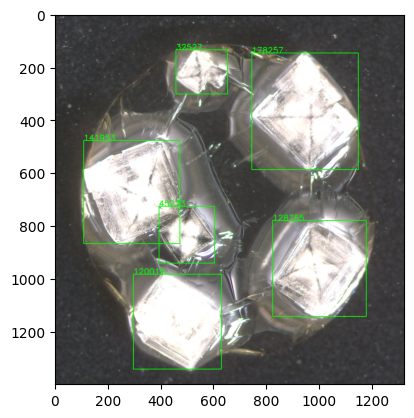


0: 1024x992 10 objects, 4425.0ms
Speed: 8.0ms preprocess, 4425.0ms inference, 65.5ms postprocess per image at shape (1, 3, 1024, 992)


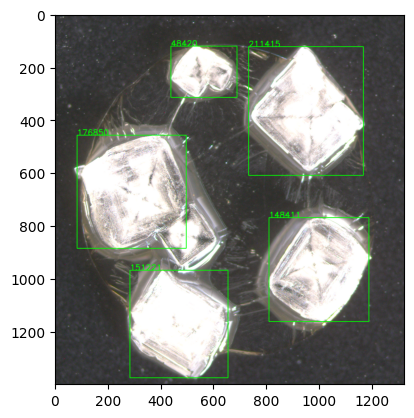


0: 1024x992 7 objects, 4303.0ms
Speed: 8.0ms preprocess, 4303.0ms inference, 46.0ms postprocess per image at shape (1, 3, 1024, 992)


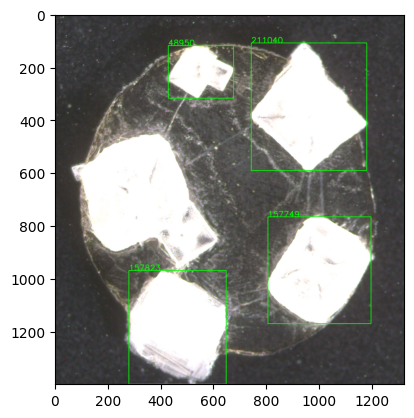


0: 1024x992 7 objects, 4170.5ms
Speed: 8.0ms preprocess, 4170.5ms inference, 46.0ms postprocess per image at shape (1, 3, 1024, 992)


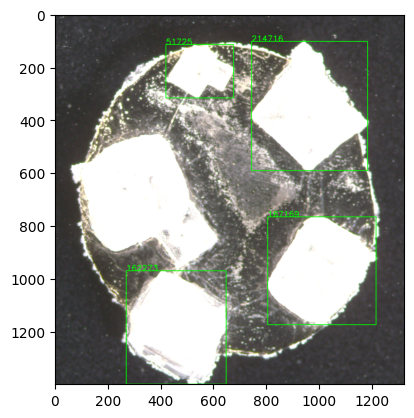

In [9]:
df_res = pd.DataFrame(columns=["file", "object_counter", "object_area_sum"])

model = FastSAM("FastSAM-x.pt")

for i, file in enumerate(cropped_files):
    object_counter = 0
    object_area_sum = 0
    filename = os.path.basename(file)

    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    everything_results = model.predict(img, device="cpu", retina_detection=True, conf=0.33)

    data = [
        {
            "xmin": box[0].item(),
            "ymin": box[1].item(),
            "xmax": box[2].item(),
            "ymax": box[3].item(),
        }
        for box in everything_results[0].boxes.xyxy
    ]
    df = pd.DataFrame(data)

    df["bbox_area"] = (df["xmax"] - df["xmin"]) * (df["ymax"] - df["ymin"])
    for idx, row in df.iterrows():
        if 10000 < row["bbox_area"] < 250000:
            object_counter += 1
            object_area_sum += row["bbox_area"]
            cv2.rectangle(
                img,
                (int(row["xmin"]), int(row["ymin"])),
                (int(row["xmax"]), int(row["ymax"])),
                (0, 255, 0),
                2,
            )
            cv2.putText(
                img,
                f"{row['bbox_area']:.0f}",
                (int(row["xmin"]), int(row["ymin"])),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2,
            )

    plt.figure()
    plt.imshow(img)
    plt.show()

    df_res.loc[i] = pd.Series(
        {
            "file": filename,
            "object_counter": object_counter,
            "object_area_sum": object_area_sum,
        }
    )

<Axes: xlabel='file'>

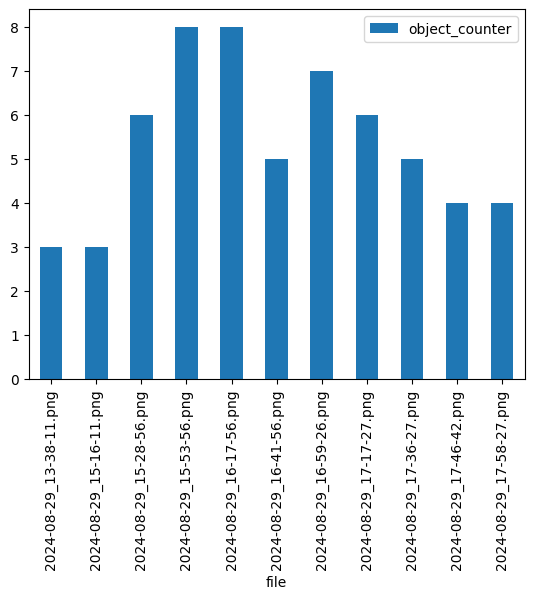

In [10]:
df_res.plot(x="file", y=["object_counter"], kind="bar")

<Axes: xlabel='file'>

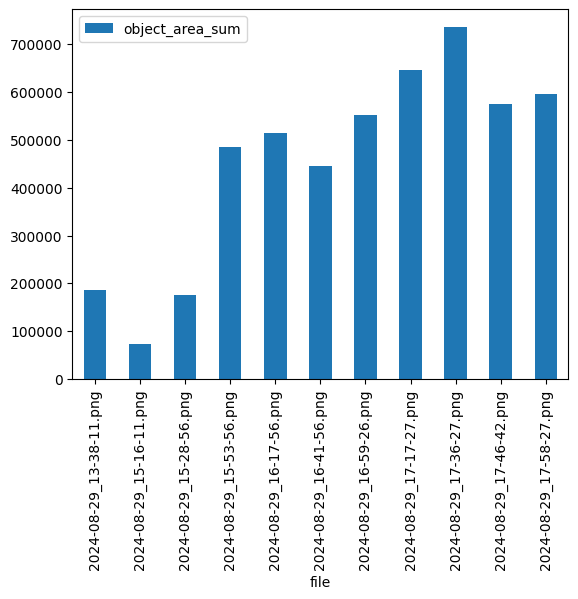

In [11]:
df_res.plot(x="file", y=["object_area_sum"], kind="bar")